

---

#### Note: Throughout the thesis code/notebooks, to reproduce different results and methods, code cells are edited and desired paramteres entered and re-ran. Code is commented out and in at times when we want to use different variables etc, this saves having lots of repeated code clogging up the notebooks


---





---
# Imports & Installations
---




In [ ]:
!pip install tensorflow-io
!pip install pydub
!pip install wget
!pip install tensorflow-addons
!pip install keras_tuner

     |████████████████████████████████| 23.4 MB 1.6 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c9914a000d82c3164cf5fff64617118fd5e2a65d6cf699132b3a3805babf6843
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
from google.colab import drive 
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import pydub
import json
import tensorflow_io as tfio
import wget
import keras_tuner as kt
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from keras.layers import *

from sklearn.metrics import roc_curve,roc_auc_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive




---

# Functions


---



In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def create_sequential(X):

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model

def evaluate_kfold(X, y, model, model_name, comps=50, X_aug=None, y_aug=None, sampling=False, cf_matrix=False, augment=False, strategy=0.5, pca=False, roc_curve=False, fig=None, ax=None):
  """ 
    Master function for training all models with cross validation.
    Auxiliary techinqeus 
    
    Input: Model, data and optional parameters
    Returns : Cross Validated Metric Scores
  """
  np.random.seed(196058)

  cv_scores = {
      'roc_auc':[],
      'f1_weighted':[],
      'f1_macro':[],
      'accuracy':[],
      'precision':[],
      'recall':[]
  }

  if roc_curve:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

  # Define stratified approach
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

  # enumerate the splits and summarize the distributions
  for train_ix, test_ix in kfold.split(X, y):
    # select rows
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    y_train = y_train.to_numpy().ravel()
    y_test = y_test.to_numpy().ravel()


    # summarize train and test composition
    # train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    # test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    # print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

    if sampling=='over':
      # do sampling on train data
      X_train_bal, y_train_bal = over_sampling(model, X_train, y_train, strategy)
      train_0, train_1 = len(y_train_bal[y_train_bal==0]), len(y_train_bal[y_train_bal==1])
      test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
      print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
      model.fit(X_train_bal, y_train_bal)
    elif sampling=='under':
      X_train_bal, y_train_bal = under_sampling(model, X_train, y_train, strategy)
      train_0, train_1 = len(y_train_bal[y_train_bal==0]), len(y_train_bal[y_train_bal==1])
      test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
      print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
      model.fit(X_train_bal, y_train_bal)
    elif sampling=='combo':
      X_train_bal, y_train_bal = combo_sampling(model, X_train, y_train, strategy)
      train_0, train_1 = len(y_train_bal[y_train_bal==0]), len(y_train_bal[y_train_bal==1])
      test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
      print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
      model.fit(X_train_bal, y_train_bal)
    elif augment==True:
      X_train = np.concatenate((X_train, X_aug), axis=0)
      y_train = np.concatenate((y_train, y_aug), axis=0)
      # print(X_train.shape, y_train.shape)
      
      model.fit(X_train, y_train)
    elif pca==True:
      pca = PCA(n_components=comps)
      X_pca_train = pca.fit_transform(X_train)
      X_test = pca.transform(X_test)

      model.fit(X_pca_train, y_train)

    else:
      model.fit(X_train, y_train)
    
    ## Predict
    y_pred = model.predict(X_test)

    # Compute various metrics
    cv_scores['roc_auc'].append( round(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) * 100, 1 ))
    cv_scores['accuracy'].append( round(metrics.accuracy_score(y_test, y_pred) * 100, 1))
    cv_scores['f1_weighted'].append( round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 1))
    cv_scores['f1_macro'].append( round(metrics.f1_score(y_test, y_pred, average='macro') * 100, 1))
    cv_scores['precision'].append( round(metrics.precision_score(y_test, y_pred, average='weighted') * 100, 1))
    cv_scores['recall'].append( round(metrics.recall_score(y_test, y_pred, average='weighted') * 100, 1))

    # Optional plotting
    if roc_curve is True:
      viz = RocCurveDisplay.from_estimator(
          model,
          X_test,
          y_test,
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  if roc_curve is True:
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance/DummyClf", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="purple",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std_tpr = np.std(tprs, axis=0)
    # tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    # tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # ax.fill_between(
    #     mean_fpr,
    #     tprs_lower,
    #     tprs_upper,
    #     color="grey",
    #     alpha=0.2,
    #     label=r"$\pm$ 1 std. dev.",
    # )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="ROC Curve - Closing 5 mins audio",
    )
    ax.legend(loc="lower right", prop={'size': 8})
    plt.show()

  res = [model_name]
  print(model_name)
  for x in cv_scores.keys():
    res.append(np.mean(cv_scores[x]))

  return res

def format_base_features(df):
  """ 
    Flattens and formats baseline features as input into ML models
    
    Input: Dataframe
    Returns : Formatted Dataframe
  """
  
  v = np.column_stack([df.id.values, df.mfcc.values.tolist()])
  c = ['id'] + ['mfcc{}'.format(i) for i in range(v.shape[1] - 1)] 
  df2 = pd.DataFrame(v, df.index, c)
  df2['zcr_max'] = df['zcr_max']
  df2['zcr_mean'] = df['zcr_mean']
  df2['title'] = df['title']
  df2['label'] = df['label']
  
  
  return df2

def format_pretrained_features(df):
  """ 
    Flattens and formats pretrained feature vectors as input into ML models
    
    Input: Dataframe
    Returns : Formatted Dataframe
  """
  v2 = np.column_stack([df.id.values, df.trill_embedding.values.tolist()])
  c2 = ['id'] + ['trill{}'.format(i) for i in range(v2.shape[1] - 1)] 
  df2 = pd.DataFrame(v2, df.index, c2)
  df2['label'] = df['label']

  return df2

def plot_roc_curve(mean_fpr, tprs, fig=None, ax=None, colour=None, first=True, avg=None, title=None):
  """
    Plot roc curve given true positive rate and false positive rate
  """

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  # mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)

  ax.plot(
    mean_fpr,
    mean_tpr,
    color=colour,
    label=(f"{title} (Mean AUC = {avg})"),
    lw=2,
    alpha=0.8,
  )

  if first:
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance/DummyClf", alpha=0.8)
    
  ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="ROC Curves - Feature Sets w/ NNs",
    )
  ax.legend(loc="lower right", prop={'size': 8})

  
  plt.show()




---

# Read and Format datasets
## Concatting and merging different datasets to experiment with feature variations

### 1. MFCC + Pretrained
### 2. MFCC + Pretrained + Title tokenizer
### 3. Title tokenizer (text only)
### 4. All features - above + podcast length
### 5. PCA
---



In [ ]:
base_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/baseline_final_dataset.json", lines=True)
# aug_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/aug_pretrained_final_dataset.json", lines=True)
trill_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/pretrained_final_dataset.json", lines=True)

# trill_df = pd.concat([trill_df, aug_df])

# Length of podcast feature
lengths_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/lengths.json", orient='records', lines=True)

In [ ]:
base_df = format_base_features(base_df)
trill_df = format_pretrained_features(trill_df)

# trill_df = pd.merge(trill_df, base_df[['id', 'title']], on='id', how='inner')
lengths_df = lengths_df.apply(pd.Series.explode)
lengths_df = lengths_df.drop('index', axis=1)

print(base_df.shape, trill_df.shape)

In [ ]:
trill_lengths_df = pd.merge(trill_df, lengths_df, on=['id'], how='inner')

cols = trill_lengths_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols[0], cols[1] = cols[1], cols[0]
trill_lengths_df = trill_lengths_df[cols]
trill_lengths_df.head(5)

,id,length,trill0,trill1,trill2,trill3,trill4,trill5,trill6,trill7,...,trill3063,trill3064,trill3065,trill3066,trill3067,trill3068,trill3069,trill3070,trill3071,label
0,0005b4e2-adad-4fab-bcce-7fd65bd17d67,4465.676213,-0.543877,0.003794,-0.493678,-0.199269,0.840421,7.275921,0.337953,-0.354071,...,0.090932,1.393066,0.141096,0.412527,0.048386,-0.590471,-0.549559,0.595041,0.309263,0
1,00287f38-ff72-4adf-87f2-8325aa3651e3,3184.865583,-0.482739,-0.224403,-0.486942,0.14512,0.742322,2.978831,0.151193,-0.789805,...,0.194617,1.294528,0.086204,0.574177,0.300023,-0.736791,-0.994188,0.326598,0.365409,1
2,002c23d0-cd29-4378-b075-aa7a657b1b57,2312.96,-0.447971,-0.233295,-0.587627,-0.091049,0.667997,2.634686,0.019293,-0.602077,...,0.056385,1.352573,0.097797,0.355569,-0.188562,-0.76192,-0.710654,0.635308,0.296647,1
3,0035c812-bf68-40a2-8c61-80b82a4cf236,2366.336,-0.446598,0.037524,-0.631987,-0.091339,0.911606,8.419353,0.354944,-0.370656,...,0.073902,1.340816,0.630626,0.545943,0.20615,-0.949928,-0.76745,0.501143,0.274363,0
4,0043b17a-f15f-41e1-850b-bac7f5b99a61,698.22675,-0.451497,-0.065233,-1.019728,-0.051426,0.830159,7.130672,-0.032217,-0.801794,...,-0.183193,1.001788,0.396808,0.416567,0.062035,-0.894173,-1.117045,0.388678,0.2236,0


In [ ]:
# mfcc_pretrained_df = pd.merge(trill_df, base_df, on=['id'], how='inner')
mfcc_pretrained_df = pd.merge(trill_lengths_df, base_df, on=['id'], how='inner')
mfcc_pretrained_df = mfcc_pretrained_df.drop('label_x', axis=1)
# mfcc_pretrained_df = mfcc_pretrained_df.drop('title', axis=1)

print("Shapes: ", mfcc_pretrained_df.shape, trill_df.shape, base_df.shape)

Shapes:  (3599, 3098) (3618, 3074) (3618, 25)




---
# 1. MFCC + Pretrained
---



23/23 [==============================] - 0s 4ms/step - loss: 0.3602 - auc_81: 0.6680


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


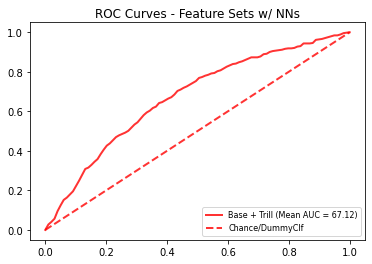

Baseline: 67.12% (0.00%)


In [ ]:
tf.random.set_seed(34)

X = mfcc_pretrained_df.iloc[:,2:-2]
y = mfcc_pretrained_df['label_y']

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

fig, ax = plt.subplots()

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# Metrics and plotting

aucs = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

y_true, y_prob = [], []
cvscores = []
for train, test in kfold.split(X, y):
  # print(train, test)
  X_train, y_train = X.iloc[train], y.iloc[train]
  X_test, y_test = X.iloc[test], y.iloc[test]

  # print(X_train.head(5))

  X_train = np.asarray(X_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  y_train = np.asarray(y_train).astype('float32')
  y_test = np.asarray(y_test).astype('float32')

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')])
  
  # class_weight = {0: 1, 1: 100.}

  # Compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.AUC()])

  model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=0)

  y_test_prob = model.predict(X_test)
  # print(y_test_prob[:3])
  loss, auc = model.evaluate(X_test, y_test)

  fpr, tpr, thresholds = roc_curve(y_test , y_test_prob)

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)

  # y_true.append(y.iloc[test])
  # y_prob.append(y_test_prob)


  # tprs.append(tpr)

  # plt.plot(fpr,tpr) 
  # plt.show()  

  cvscores.append(auc)

# ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance/DummyClf", alpha=0.8)

plot_roc_curve(mean_fpr, tprs, fig, ax, colour='r', avg=round(np.mean(cvscores)*100, 2), title='Base + Trill')

# plot_pr_curve(y_true, y_prob)

# estimator = KerasClassifier(build_fn= lambda: create_sequential(X), epochs=20, batch_size=64, verbose=0)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# results = cross_val_score(estimator, X, y, cv=kfold, scoring='roc_auc')
print("Baseline: %.2f%% (%.2f%%)" % (np.mean(cvscores)*100, np.mean(cvscores).std()*100))



---

## 2. MFCC + Pretrained + Podcast Length


---



---



In [ ]:
tf.random.set_seed(34)

# exclude title and include length with slices
X = mfcc_pretrained_df.iloc[:,1:-2]
y = mfcc_pretrained_df['label_y']

scaler = StandardScaler()
X[['length']] = scaler.fit_transform(X[['length']])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

aucs = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

cvscores = []
for train, test in kfold.split(X, y):
  X_train, y_train = X.iloc[train], y.iloc[train]
  X_test, y_test = X.iloc[test], y.iloc[test]

  X_train = np.asarray(X_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  y_train = np.asarray(y_train).astype('float32')
  y_test = np.asarray(y_test).astype('float32')

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')])
  
  # class_weight = {0: 1, 1: 100.}

  # Compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.AUC()])

  model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=0) #, class_weight=class_weight)

  y_test_prob = model.predict(X_test)
  loss, auc = model.evaluate(X_test, y_test)

  fpr, tpr, thresholds = roc_curve(y_test , y_test_prob)

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)


  loss, auc = model.evaluate(X_test, y_test)

  cvscores.append(auc)

# plot_roc_curve(mean_fpr, tprs, fig, ax)

plot_roc_curve(mean_fpr, tprs, fig, ax, colour='b', avg=round(np.mean(cvscores)*100, 2), title='Base + Trill + Length', first=False)

# estimator = KerasClassifier(build_fn= lambda: create_sequential(X), epochs=20, batch_size=64, verbose=0)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# results = cross_val_score(estimator, X, y, cv=kfold, scoring='roc_auc')
print("Baseline: %.2f%% (%.2f%%)" % (np.mean(cvscores)*100, np.mean(cvscores).std()*100))

23/23 [==============================] - 0s 4ms/step - loss: 0.3544 - auc_86: 0.6676
Baseline: 67.59% (0.00%)


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


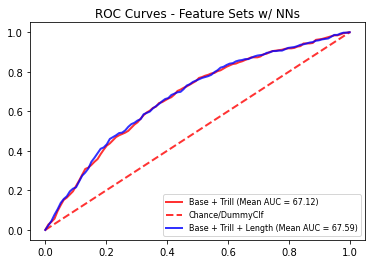

In [ ]:
fig



---

## 3. Numeric + NLP featurees

---



In [ ]:
np.random.seed(78)
tf.random.set_seed(74)

# trill + title
X = pd.concat([mfcc_pretrained_df.iloc[:,1:-2], mfcc_pretrained_df.title], axis=1)
# X = pd.concat([trill_lengths_df.iloc[:,1:-2], trill_lengths_df.title], axis=1)
# X = pd.concat([trill_df.iloc[:,1:-2], trill_df.title], axis=1)
y = mfcc_pretrained_df['label_y']

scaler = StandardScaler()
X[['length']] = scaler.fit_transform(X[['length']])

# # Define stratified approach
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

print(X.shape)
# X = X3
cvscores = []
for train, test in kfold.split(X, y):
  # print(train, test)
  X_train, y_train = X.iloc[train], y.iloc[train]
  X_test, y_test = X.iloc[test], y.iloc[test]

  title_train = X_train['title']
  title_test = X_test['title']


  #subsetting the numeric variables
  numeric_train = X_train.iloc[:,:-1].to_numpy()
  numeric_test = X_test.iloc[:,:-1].to_numpy()

  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=100)
  tokenizer.fit_on_texts(title_train)
  sequences_train = tokenizer.texts_to_sequences(title_train)
  sequences_test = tokenizer.texts_to_sequences(title_test)

  word2idx = tokenizer.word_index
  V = len(word2idx)

  nlp_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train)

  # get sequence length
  T = nlp_train.shape[1]

  nlp_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=T)

  # Choosing embedding dimensionality
  D = 20

  # Hidden state dimensionality
  M = 40

  nlp_input = Input(shape=(T,),name= 'nlp_input')
  meta_input = Input(shape=(3095,), name='meta_input')
  emb = Embedding(V + 1, D)(nlp_input)
  emb = GlobalAveragePooling1D()(emb)
  emb = tf.expand_dims(emb, axis=-1)
  emb = Bidirectional(LSTM(64, return_sequences=True))(emb)
  emb = Dropout(0.40)(emb)
  emb = Bidirectional(LSTM(128))(emb)
  nlp_out = Dropout(0.40)(emb)
  
  x = tf.concat([nlp_out, meta_input], 1)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[nlp_input, meta_input], outputs=[x])

  numeric_train = numeric_train.astype('float32')
  nlp_train = nlp_train.astype('float32')
  numeric_test = numeric_test.astype('float32')
  nlp_test = nlp_test.astype('float32')

  # Compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.AUC()]) #, tfa.metrics.F1Score(num_classes=1, average='weighted'), 'accuracy'])
  
  # class_weight = {0: 1., 1: 100.}

  model.fit([nlp_train, numeric_train], y_train, batch_size=64, epochs=20, verbose=0)

  loss, auc = model.evaluate([nlp_test, numeric_test], y_test)

  y_test_prob = model.predict([nlp_test, numeric_test])
  # print(y_test_prob[:3])
  # loss, auc = model.evaluate(X_test, y_test)

  fpr, tpr, thresholds = roc_curve(y_test , y_test_prob)

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)

  cvscores.append(auc)

print(np.mean(cvscores))


plot_roc_curve(mean_fpr, tprs, fig, ax, colour='g', avg=round(np.mean(cvscores)*100, 2), title='Numeric + Title', first=False)
print("Baseline: %.2f%% (%.2f%%)" % (np.mean(cvscores)*100, np.mean(cvscores).std()*100))

(3599, 3096)
23/23 [==============================] - 2s 15ms/step - loss: 0.3611 - auc_91: 0.6629
0.6791158437728881
Baseline: 67.91% (0.00%)


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


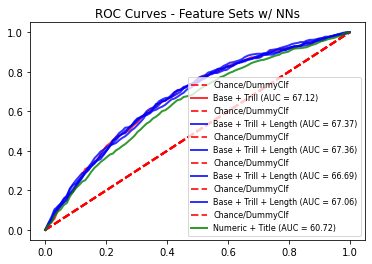

In [ ]:
fig



---

## 4. Just Title/text features

---



In [ ]:
np.random.seed(78)
tf.random.set_seed(74)

# trill + title
X = pd.concat([mfcc_pretrained_df.iloc[:,1:-2], mfcc_pretrained_df.title], axis=1)
# X = pd.concat([trill_lengths_df.iloc[:,1:-2], trill_lengths_df.title], axis=1)
# X = pd.concat([trill_df.iloc[:,1:-2], trill_df.title], axis=1)
y = mfcc_pretrained_df['label_y']

scaler = StandardScaler()
X[['length']] = scaler.fit_transform(X[['length']])

# # Define stratified approach
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

cvscores = []
for train, test in kfold.split(X, y):
  # print(train, test)
  X_train, y_train = X.iloc[train], y.iloc[train]
  X_test, y_test = X.iloc[test], y.iloc[test]

  title_train = X_train['title']
  title_test = X_test['title']

  #subsetting the numeric variables
  numeric_train = X_train.iloc[:,:-1].to_numpy()
  numeric_test = X_test.iloc[:,:-1].to_numpy()

  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=100)
  tokenizer.fit_on_texts(title_train)
  sequences_train = tokenizer.texts_to_sequences(title_train)
  sequences_test = tokenizer.texts_to_sequences(title_test)

  word2idx = tokenizer.word_index
  V = len(word2idx)

  nlp_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train)

  # get sequence length
  T = nlp_train.shape[1]

  nlp_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=T)

  # Choosing embedding dimensionality
  D = 20

  # Hidden state dimensionality
  M = 40

  nlp_input = Input(shape=(T,),name= 'nlp_input')
  # meta_input = Input(shape=(3094,), name='meta_input')
  emb = Embedding(V + 1, D)(nlp_input)
  emb = Bidirectional(LSTM(64, return_sequences=True))(emb)
  emb = Dropout(0.40)(emb)
  emb = Bidirectional(LSTM(128))(emb)
  nlp_out = Dropout(0.40)(emb)
  x = Dense(64, activation='swish')(nlp_out)
  x = Dropout(0.20)(x)
  x = Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[nlp_input], outputs=[x])

  numeric_train = numeric_train.astype('float32')
  nlp_train = nlp_train.astype('float32')
  numeric_test = numeric_test.astype('float32')
  nlp_test = nlp_test.astype('float32')

  # Compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer="adam",
                  metrics=[tf.keras.metrics.AUC()]) #, tfa.metrics.F1Score(num_classes=1, average='weighted'), 'accuracy'])
  
  model.fit(nlp_train, y_train, batch_size=64, epochs=20, verbose=0)


  loss, auc = model.evaluate(nlp_test, y_test)
  y_test_prob = model.predict(nlp_test)
  # print(y_test_prob[:3])
  # loss, auc = model.evaluate(X_test, y_test)

  fpr, tpr, thresholds = roc_curve(y_test , y_test_prob)

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)

  cvscores.append(auc)

print(np.mean(cvscores))


plot_roc_curve(mean_fpr, tprs, fig, ax, colour='yellow', avg=round(np.mean(cvscores)*100, 2), title='Title', first=False)
print("Baseline: %.2f%% (%.2f%%)" % (np.mean(cvscores)*100, np.mean(cvscores).std()*100))

23/23 [==============================] - 2s 13ms/step - loss: 0.4059 - auc_96: 0.4930
0.5305465400218964
Baseline: 53.05% (0.00%)


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




---

# TFIDF + Trill - Traditional Classifiers


---



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer()
x = v.fit_transform(trill_df['title'])

df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

df1 = pd.concat([trill_df, df1], axis=1)

df1 = df1.drop('title', axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df1.head(5)

,id,trill0,trill1,trill2,trill3,trill4,trill5,trill6,trill7,trill8,...,zoe,zoila,zombie,zomparelli,zone,zoo,zordon,zuckerberg,zweck,zwift
0,0005b4e2-adad-4fab-bcce-7fd65bd17d67,-0.543877,0.003794,-0.493678,-0.199269,0.840421,7.275921,0.337953,-0.354071,-0.782924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00287f38-ff72-4adf-87f2-8325aa3651e3,-0.482739,-0.224403,-0.486942,0.14512,0.742322,2.978831,0.151193,-0.789805,-0.711518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,002c23d0-cd29-4378-b075-aa7a657b1b57,-0.447971,-0.233295,-0.587627,-0.091049,0.667997,2.634686,0.019293,-0.602077,-0.826154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0035c812-bf68-40a2-8c61-80b82a4cf236,-0.446598,0.037524,-0.631987,-0.091339,0.911606,8.419353,0.354944,-0.370656,-0.831448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0043b17a-f15f-41e1-850b-bac7f5b99a61,-0.451497,-0.065233,-1.019728,-0.051426,0.830159,7.130672,-0.032217,-0.801794,-0.955623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create dict of X, y for easy reuse of splits for both feature sets
splits = {}

X = df1.iloc[:,1:-1]
y = df1['label'].iloc[:,:-1]
splits['tfidf'] = [X, y]

# X = new_trill_df.iloc[:,1:-1]
# y = new_trill_df['label']
# splits['aug_trill'] = [X, y]

# alphabetical order todo
# Range of baseline models to train and evaluate
classification_models = [
    KNeighborsClassifier(),
    # SVC(kernel='linear', probability=True),
    LogisticRegression(),   #C=1.0, class_weight={0: 0.9850251256281407, 1: 0.014974874371859292}, penalty='l2', solver='newton-cg'), #(C=100, penalty='l2', max_iter=1000)] #, #C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier(),
    GradientBoostingClassifier()]

In [ ]:
X, y = splits['tfidf'][0], splits['tfidf'][1]

scaler = StandardScaler()

X = df1.iloc[:,1:3073]
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

X = pd.concat([X, df1.iloc[:,3073:-1]], axis=1)
y = df1['label'].iloc[:,:-1]

X = X.drop('label', axis=1)

# X[X.iloc[:,1:3073]] = scaler.fit_transform(X.iloc[:,1:3073])
# keep our unscaled features just in case we need to process them alternatively
# features_scaled = X 
# features_scaled = scaler.fit_transform(features_scaled)

# For each model get CV scores and evaluate on test set
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(X, y, model, model_name, pca=False)
    print(kfold_score)
    # Append model scores for comparison
    scores.append(kfold_score)

df = pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
df = df.sort_values(by=['Classifier'])
# df = df.applymap(lambda x: (str(x) + '%'))
df.head(6)

KNeighborsClassifier
['KNeighborsClassifier', 54.8, 82.02000000000001, 49.74, 86.08000000000001, 79.58, 86.08000000000001]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression
['LogisticRegression', 63.96, 82.62, 53.36, 85.5, 80.92, 85.5]
DecisionTreeClassifier
['DecisionTreeClassifier', 54.28000000000001, 81.36, 48.839999999999996, 85.08, 78.61999999999999, 85.08]
AdaBoostClassifier
['AdaBoostClassifier', 63.160000000000004, 82.4, 52.739999999999995, 85.32000000000001, 80.5, 85.32000000000001]
GradientBoostingClassifier
['GradientBoostingClassifier', 66.1, 82.2, 47.94, 87.47999999999999, 80.02000000000001, 87.47999999999999]


,Classifier,roc_auc,f1_weighted,f1_macro,accuracy,precision,recall
3,AdaBoostClassifier,63.16,82.40,52.74,85.32,80.50,85.32
2,DecisionTreeClassifier,54.28,81.36,48.84,85.08,78.62,85.08
4,GradientBoostingClassifier,66.10,82.20,47.94,87.48,80.02,87.48
0,KNeighborsClassifier,54.80,82.02,49.74,86.08,79.58,86.08
1,LogisticRegression,63.96,82.62,53.36,85.50,80.92,85.50


In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n                Classifier &  roc\\_auc &  f1\\_weighted &  f1\\_macro &  accuracy &  precision &  recall \\\\\n\\midrule\n        AdaBoostClassifier &    63.16 &        82.40 &     52.74 &     85.32 &      80.50 &   85.32 \\\\\n    DecisionTreeClassifier &    54.28 &        81.36 &     48.84 &     85.08 &      78.62 &   85.08 \\\\\nGradientBoostingClassifier &    66.10 &        82.20 &     47.94 &     87.48 &      80.02 &   87.48 \\\\\n      KNeighborsClassifier &    54.80 &        82.02 &     49.74 &     86.08 &      79.58 &   86.08 \\\\\n        LogisticRegression &    63.96 &        82.62 &     53.36 &     85.50 &      80.92 &   85.50 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
X, y = splits['tfidf'][0], splits['tfidf'][1]

# X = pd.concat([X, df1.iloc[:,3073:-1]], axis=1)
X = df1.iloc[:,3073:-1]
y = df1['label'].iloc[:,:-1]

X = X.drop('label', axis=1)

In [ ]:
y

,label
0,0
1,1
2,1
3,0
4,0
...,...
3613,0
3614,0
3615,0
3616,0


In [ ]:
X, y = splits['tfidf'][0], splits['tfidf'][1]

# X = pd.concat([X, df1.iloc[:,3073:-1]], axis=1)
X = df1.iloc[:,3073:-1]
y = df1['label'].iloc[:,:-1]

X = X.drop('label', axis=1)

# X[X.iloc[:,1:3073]] = scaler.fit_transform(X.iloc[:,1:3073])
# keep our unscaled features just in case we need to process them alternatively
# features_scaled = X 
# features_scaled = scaler.fit_transform(features_scaled)

# For each model get CV scores and evaluate on test set
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(X, y, model, model_name, pca=100)
    print(kfold_score)
    # Append model scores for comparison
    scores.append(kfold_score)

df = pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
df = df.sort_values(by=['Classifier'])
# df = df.applymap(lambda x: (str(x) + '%'))
df.head(6)

KNeighborsClassifier
['KNeighborsClassifier', 52.04, 81.94000000000001, 47.36, 87.08, 78.46000000000001, 87.08]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

LogisticRegression
['LogisticRegression', 55.4, 82.08, 46.760000000000005, 87.76, 77.04, 87.76]
DecisionTreeClassifier
['DecisionTreeClassifier', 50.46, 82.26, 47.98, 87.58, 81.02000000000001, 87.58]
AdaBoostClassifier
['AdaBoostClassifier', 54.18000000000001, 82.1, 49.24, 86.5, 79.68, 86.5]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier
['GradientBoostingClassifier', 55.02, 82.12, 47.14, 87.63999999999999, 78.72, 87.63999999999999]


,Classifier,roc_auc,f1_weighted,f1_macro,accuracy,precision,recall
3,AdaBoostClassifier,54.18,82.10,49.24,86.50,79.68,86.50
2,DecisionTreeClassifier,50.46,82.26,47.98,87.58,81.02,87.58
4,GradientBoostingClassifier,55.02,82.12,47.14,87.64,78.72,87.64
0,KNeighborsClassifier,52.04,81.94,47.36,87.08,78.46,87.08
1,LogisticRegression,55.40,82.08,46.76,87.76,77.04,87.76


In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n                Classifier &  roc\\_auc &  f1\\_weighted &  f1\\_macro &  accuracy &  precision &  recall \\\\\n\\midrule\n        AdaBoostClassifier &    54.18 &        82.10 &     49.24 &     86.50 &      79.68 &   86.50 \\\\\n    DecisionTreeClassifier &    50.46 &        82.26 &     47.98 &     87.58 &      81.02 &   87.58 \\\\\nGradientBoostingClassifier &    55.02 &        82.12 &     47.14 &     87.64 &      78.72 &   87.64 \\\\\n      KNeighborsClassifier &    52.04 &        81.94 &     47.36 &     87.08 &      78.46 &   87.08 \\\\\n        LogisticRegression &    55.40 &        82.08 &     46.76 &     87.76 &      77.04 &   87.76 \\\\\n\\bottomrule\n\\end{tabular}\n'



---

## TFIDF + Trill + Aug + PCA


---



In [ ]:
X, y = splits['tfidf'][0], splits['tfidf'][1]

scaler = StandardScaler()

X = df1.iloc[:,1:3073]
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

X = pd.concat([X, df1.iloc[:,3073:-1]], axis=1)
y = df1['label'].iloc[:,:-1]

X = X.drop('label', axis=1)

# X[X.iloc[:,1:3073]] = scaler.fit_transform(X.iloc[:,1:3073])
# keep our unscaled features just in case we need to process them alternatively
# features_scaled = X 
# features_scaled = scaler.fit_transform(features_scaled)

# For each model get CV scores and evaluate on test set
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(X, y, model, model_name, pca=True, comps=50)
    print(kfold_score)
    # Append model scores for comparison
    scores.append(kfold_score)

df = pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
df = df.sort_values(by=['Classifier'])
# df = df.applymap(lambda x: (str(x) + '%'))
df.head(6)

KNeighborsClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


['KNeighborsClassifier', 59.54, 82.60000000000001, 51.58, 86.33999999999999, 80.86, 86.33999999999999]
LogisticRegression
['LogisticRegression', 67.75999999999999, 82.86000000000001, 50.82000000000001, 87.3, 80.9, 87.3]
DecisionTreeClassifier
['DecisionTreeClassifier', 55.6, 82.44, 48.6, 87.58, 81.72, 87.58]
AdaBoostClassifier
['AdaBoostClassifier', 64.47999999999999, 82.67999999999999, 50.8, 86.86, 80.94, 86.86]
GradientBoostingClassifier
['GradientBoostingClassifier', 68.88, 82.58000000000001, 48.559999999999995, 87.94000000000001, 85.3, 87.94000000000001]


,Classifier,roc_auc,f1_weighted,f1_macro,accuracy,precision,recall
3,AdaBoostClassifier,64.48,82.68,50.80,86.86,80.94,86.86
2,DecisionTreeClassifier,55.60,82.44,48.60,87.58,81.72,87.58
4,GradientBoostingClassifier,68.88,82.58,48.56,87.94,85.30,87.94
0,KNeighborsClassifier,59.54,82.60,51.58,86.34,80.86,86.34
1,LogisticRegression,67.76,82.86,50.82,87.30,80.90,87.30


In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n                Classifier &  roc\\_auc &  f1\\_weighted &  f1\\_macro &  accuracy &  precision &  recall \\\\\n\\midrule\n        AdaBoostClassifier &    64.48 &        82.68 &     50.80 &     86.86 &      80.94 &   86.86 \\\\\n    DecisionTreeClassifier &    55.60 &        82.44 &     48.60 &     87.58 &      81.72 &   87.58 \\\\\nGradientBoostingClassifier &    68.88 &        82.58 &     48.56 &     87.94 &      85.30 &   87.94 \\\\\n      KNeighborsClassifier &    59.54 &        82.60 &     51.58 &     86.34 &      80.86 &   86.34 \\\\\n        LogisticRegression &    67.76 &        82.86 &     50.82 &     87.30 &      80.90 &   87.30 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
# X, y = splits['tfidf'][0], splits['tfidf'][1]

# scaler = StandardScaler()

# X = df1.iloc[:,1:3073]
# features_scaled = X 
# features_scaled = scaler.fit_transform(features_scaled)

# X = pd.concat([X, df1.iloc[:,3073:-1]], axis=1)
# y = df1['label'].iloc[:,:-1]
# ``````
# X = X.drop('label', axis=1)

# # X[X.iloc[:,1:3073]] = scaler.fit_transform(X.iloc[:,1:3073])
# # keep our unscaled features just in case we need to process them alternatively
# # features_scaled = X 
# # features_scaled = scaler.fit_transform(features_scaled)

# # For each model get CV scores and evaluate on test set
# scores = []
# for model in classification_models:
#     model_name = type(model).__name__
    
#     # Evaluate with kfold validation (custom func)
#     kfold_score = evaluate_kfold(X, y, model, model_name, pca=True, comps=50)
#     print(kfold_score)
#     # Append model scores for comparison
#     scores.append(kfold_score)

# df = pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
# df = df.sort_values(by=['Classifier'])
# # df = df.applymap(lambda x: (str(x) + '%'))
# df.head(6)

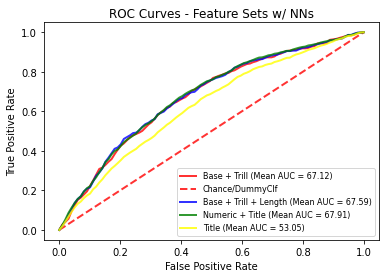

In [ ]:
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
fig



---

# TFIDF + Trill - Sequential model



---



In [ ]:
import tensorflow_addons as tfa
np.random.seed(5)

# X = np.array(new_trill_df.trill_embedding.tolist()).astype('float32')
# Y = np.array(new_trill_df.label.tolist()).astype('float32')

# Y = Y.reshape((Y.shape[0], -1))
Y = np.array(df1.label_y.tolist()).astype('float32')
Y = Y.reshape((Y.shape[0], -1))

df1 = df1.drop('label_y', axis=1)



In [ ]:
df1 = df1.drop('title', axis=1)
X = df1.iloc[:,1:-1].to_numpy(dtype='float32') #.astype('float32')

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def create_baseline():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(12487,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model

tf.random.set_seed(34)
estimator = KerasClassifier(build_fn=create_baseline, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
results = cross_val_score(estimator, X, Y, cv=kfold, scoring='roc_auc', verbose=10)
# kfold_score = evaluate_kfold(X, Y, estimator, X_aug, y_aug)

# print(kfold_score)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.652) total time=  12.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV] END ................................ score: (test=0.720) total time=  12.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.2s remaining:    0.0s


[CV] END ................................ score: (test=0.683) total time=  13.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.1s remaining:    0.0s


[CV] END ................................ score: (test=0.652) total time=  15.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   54.6s remaining:    0.0s


[CV] END ................................ score: (test=0.669) total time=  11.8s
Baseline: 67.52% (2.54%)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
